# 0. Setup

## --- 0.1. Libraries importing ---

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# dataframe manipulation
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# visualization
from matplotlib import pyplot as plt
import seaborn as sns

# TSA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# set notebook width to 100%
from IPython.core.display import display, HTML, Markdown
display(HTML("<style>.container { width:100% !important; }</style>"))

## --- 0.2. Parameters ---

In [2]:
# data you want to load
data_path = 'data/sales_prepared.csv'

# columns of the data (time_column, phenomenon_column)
time_column = 'Date'
phenomenon_column = 'Laptops_Sale'
alpha = 0.05

# 1. Functions 

## --- 1.1. Exploratory functions ---

In [3]:
def format_plot(ax, size_axes=14, size_title=15):
    font_title = {"size": size_title, "weight": 600, "name": "monospace"}

    font_axes = {"size": size_axes, "weight": "bold", "name": "monospace"}

    ax.grid(True, linestyle=":", alpha=0.6)
    sns.despine(ax=ax, left=True)

    if ax.get_legend():
        ax.legend(bbox_to_anchor=(1.1, 1))

    ax.set_title(f"\n\n{ax.get_title()}\n", fontdict=font_title)
    ax.set_xlabel(f"\n{ax.get_xlabel()} ➞", fontdict=font_axes)
    ax.set_ylabel(f"{ax.get_ylabel()} ➞\n", fontdict=font_axes)
    
def plot_time_seria_line_chart(df, time_column, phenomenon_column, diff=0):
    df_plot = (df
               .assign(index=list(map(str, np.arange(len(df)))))
              )
    
    _, ax = plt.subplots(1,1, figsize=(len(df_plot) / 3, len(df_plot)*0.1))
    sns.lineplot(data=df_plot,
                 x='index',
                 y=phenomenon_column,
                 ax=ax)
    
    indices_vl = [ind for ind in list(map(int, df_plot['index'].values)) if ((ind + 1 + diff) % 12 == 0)]
    ymax = df_plot[phenomenon_column].max()
    for i in indices_vl:
        ax.axvline(x=i,
                   ymin=0,
                   ymax=ymax,
                   color='#228B22',
                   linestyle='--')
    
    ax.set_xticklabels(
                       (df_plot[time_column]
                        .astype(str)
                        .apply(lambda x: x.split(' ')[0])
                        .values
                        ),
                       rotation=90,
                       fontsize=12
                      )
    
    ax.set_yticklabels(ax.get_yticklabels(),
                       fontsize=(len(df_plot) / 8)
                      )
    
    ax.set_xlabel(time_column)
    
    ax.set_ylabel(phenomenon_column)
    ax.set_title(f'{phenomenon_column} in Time Seria')

    format_plot(ax,
                size_axes=(len(df) / 5),
                size_title=(len(df) / 4))    
    
    plt.show()  
    
def plot_time_seria_boxplot_per_year(df, time_column, phenomenon_column):
    df_plot = df.copy()
    
    df_plot['Year'] = (df[time_column]
                       .apply(lambda x: x.year)
                      )
    
    _, ax = plt.subplots(1,1, figsize=(len(df_plot) / 3, len(df_plot)*0.1))
    sns.boxplot(x=df_plot['Year'].values,
                y=df_plot[phenomenon_column].values,
                ax=ax)
    
    ax.set_xticklabels(ax.get_xticklabels(),
                       fontsize=(len(df_plot) / 8)
                      )
    
    ax.set_yticklabels(ax.get_yticklabels(),
                       fontsize=(len(df_plot) / 8)
                      )
    
    ax.set_xlabel('Year')
    
    ax.set_ylabel(phenomenon_column)
    ax.set_title(f'Distribution of {phenomenon_column} within Years')
    
    format_plot(ax=ax,
                size_axes=(len(df) / 5),
                size_title=(len(df) / 4))
    
    plt.show()
    
def display_descriptive_statistics_per_year(df, time_column, phenomenon_column):
    df_desc_stat = (df
                    .copy()
                    .assign(Year=df[time_column].apply(lambda x: x.year).values)
                    .groupby('Year')
                    .agg(['mean', 'std'])
                   )
    
    df_desc_stat.columns = ['mean', 'std']
    
    df_desc_stat = (df_desc_stat
                    .assign(Coefficient_Of_Variation=lambda x: (x['std'] / x['mean'])*100)
                    .round(2)
                    .rename(columns={
                                        'mean':'Mean',
                                        'std':'Standard Deviation',
                                        'Coefficient_Of_Variation':'Coefficient Of Variation (%)'
                                    }
                           )
                    .reset_index()
                   )
    
    _, ax = plt.subplots(1,3, figsize=(len(df) / 3, 7))
    
    # Mean
    sns.lineplot(data=df_desc_stat,
                 x='Year',
                 y='Mean',
                 color='#00C957',
                 ax=ax[0])
    
    ax[0].set_xticklabels(ax[0].get_xticklabels(),
                          fontsize=(len(df) / 9)
                         )
    
    ax[0].set_yticklabels(ax[0].get_yticklabels(),
                          fontsize=(len(df) / 9)
                         )
    
    ax[0].set_ylabel('Value')
    ax[0].set_title('Mean')
    
    # Std
    sns.lineplot(data=df_desc_stat,
                 x='Year',
                 y='Standard Deviation',
                 color='#FF3030',
                 ax=ax[1])
    
    ax[1].set_xticklabels(ax[1].get_xticklabels(),
                          fontsize=(len(df) / 9)
                         )
    
    ax[1].set_yticklabels(ax[1].get_yticklabels(),
                          fontsize=(len(df) / 9)
                         )
    
    ax[1].set_ylabel('Value')
    ax[1].set_title('Standard Deviation')
        
    # Coef Of Var
    sns.lineplot(data=df_desc_stat,
                 x='Year',
                 y='Coefficient Of Variation (%)',
                 color='#6959CD',
                 ax=ax[2])
    
    ax[2].set_ylim(0, 100)

    ax[2].set_xticklabels(ax[2].get_xticklabels(),
                          fontsize=(len(df) / 9)
                         )
    
    ax[2].set_yticklabels(ax[2].get_yticklabels(),
                          fontsize=(len(df) / 9)
                         )
    
    ax[2].set_ylabel('Value')
    ax[2].set_title('CoV (%)')    
    
    # format plots
    format_plot(ax=ax[0],
                size_title=18,
                size_axes=14)
    
    format_plot(ax[1],
                size_title=18,
                size_axes=14)
    
    format_plot(ax[2],
                size_title=18,
                size_axes=14)
    
    plt.show()

## --- 1.2. Modeling functions ---

In [4]:
def plot_autocorrelations(df, nlags):
    _, ax = plt.subplots(1,2,figsize=(nlags, 6))
    
    # 1. AutoCorrelation
    acf_plot = plot_acf(x=df,
                        lags=nlags,
                        ax=ax[0])
    
    ax[0].set_ylim(-1.1, 1.1)
    ax[0].set_xticks(np.arange(0, nlags+1))
    
    ax[0].set_xlabel('Lag')
    ax[0].set_ylabel('AutoCorrelation')
    ax[0].set_title('AutoCorrelation Function')
    
    format_plot(ax=ax[0],
                size_title=16,
                size_axes=12)
    
    # 2. Partial AutoCorellation
    pacf_plot = plot_pacf(x=df,
                          lags=nlags,
                          ax=ax[1])
    
    ax[1].set_ylim(-1.1, 1.1)  
    ax[1].set_xticks(np.arange(0, nlags+1))
    
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Partial AutoCorrelation')
    ax[1].set_title('Partial AutoCorrelation Function')
    
    format_plot(ax=ax[1],
                size_title=16,
                size_axes=12)
        
    plt.show()
    
def differentiate_until_stationarity(df, time_column, phenomenon_column, nlags=20, alpha=0.05):
    diff, condition = 0, True
    while condition:
        p_value = adfuller(df)[1]
        display(Markdown(f'**Diferentiation: {diff}, ADF test p-value: {np.round(p_value, 3)}**'))
        plot_time_seria_line_chart(df=(df
                                       .reset_index()
                                      ),
                                   time_column=time_column,
                                   phenomenon_column=phenomenon_column,
                                   diff=diff)
                         
        plot_autocorrelations(df, nlags)
        
        if p_value >= alpha:
            df = (df
                  .diff()
                  .dropna()
                 )
        
        diff, condition = (diff + 1), (p_value >= alpha)
        
def residuals_check(arima_model):
    df_plot = (arima_model
               .resid[1:]
               .reset_index()
               .rename(columns={0:'Residual'})
              )
    
    _, ax = plt.subplots(1,2,figsize=(len(df_plot) / 7, 7))
    
    # 1. LineChart
    sns.lineplot(data=df_plot,
                 x='Date',
                 y='Residual',
                 ax=ax[0])
    
    ax[0].set_ylabel('Value')
    ax[0].set_title('Residuals Time Seria')
    
    # 2. Density
    df_plot['Residual'].plot(kind='kde',
                             ax=ax[1])
    
    ax[1].set_ylabel('')
    ax[1].set_title('Residuals Density Function')
    
    format_plot(ax[0])
    format_plot(ax[1])
    
    plt.show()
        
def plot_actual_and_forecasted_values(model, df, time_column, phenomenon_column, num_forcasts):
    df_actual = (df
                 .reset_index()
                 .assign(Forecast=0)
                )
        
    df_forcasts = (model
                   .forecast(num_forcasts)
                   .reset_index()
                   .rename(columns={'index':time_column, 'predicted_mean': phenomenon_column})
                   .assign(Forecast=1)
                  )
        
    df_plot = (pd
               .concat(objs=[df_actual, df_forcasts], axis=0) 
               .reset_index(drop=True)
               .assign(index=list(map(str, np.arange(len(df_actual) + len(df_forcasts)))))
              )
            
    _, ax = plt.subplots(1,1,figsize=(len(df_plot) / 3, len(df_plot)*0.1))
    
    # Actual values
    sns.lineplot(data=(df_plot
                       .query(f'Forecast == 0')
                      ),
                 x='index',
                 y=phenomenon_column,
                 color='#1C86EE',
                 label='Actual',
                 ax=ax)
        
    # Forecasted values
    sns.lineplot(data=(df_plot
                       .query(f'Forecast == 1')
                      ),
                 x='index',
                 y=phenomenon_column,
                 color='#FF7D40',
                 label='Forecast',
                 ax=ax)
    
    # Forecasted values - 2 stds
    sns.lineplot(data=(df_plot
                       .query(f'Forecast == 1')
                       .assign(Standard_Deviation=lambda x: x[phenomenon_column].std())
                       .assign(Y_values_offset=lambda x: x[phenomenon_column] - 2*x['Standard_Deviation'])
                      ),
                 x='index',
                 y='Y_values_offset',
                 color='#7A378B',
                 linestyle='dashed',
                 label='Forecast ± 2 S.E',
                 ax=ax)
    
    # Forecasted values + 2 stds
    sns.lineplot(data=(df_plot
                       .query(f'Forecast == 1')
                       .assign(Standard_Deviation=lambda x: x[phenomenon_column].std())
                       .assign(Y_values_offset=lambda x: x[phenomenon_column] + 2*x['Standard_Deviation'])
                      ),
                 x='index',
                 y='Y_values_offset',
                 color='#7A378B',
                 linestyle='dashed',
                 ax=ax)
    
    indices_vl = [ind for ind in list(map(int, df_plot['index'].values)) if ((ind + 1) % 12 == 0)]
    ymax = df_plot[phenomenon_column].max()
    for i in indices_vl:
        ax.axvline(x=i,
                   ymin=0,
                   ymax=ymax,
                   color='#228B22',
                   linestyle='--')
        
    ax.set_xticklabels(
                       (df_plot[time_column]
                        .astype(str)
                        .apply(lambda x: x.split(' ')[0])
                        .values
                        ),
                       rotation=90,
                       fontsize=12
                      )
    
    ax.set_yticklabels(ax.get_yticklabels(),
                       fontsize=(len(df_plot) / 8)
                      )
    
    ax.set_xlabel(time_column)
    
    ax.set_ylabel(phenomenon_column)
    ax.set_title(f'{phenomenon_column} in Time Seria')

    format_plot(ax,
                size_axes=(len(df) / 5),
                size_title=(len(df) / 4)) 
    
    ax.legend(fontsize=(len(df) / 6))
    
    plt.show()

# 2. Data loading

In [5]:
### 1. Load initial Data
df = (pd.read_csv(data_path))
df[time_column] = df[time_column].astype('datetime64')

display(df.head())
print(f'Shape of the data: {df.shape}.')

,Date,Laptops_Sale
0,2010-01-31,932
1,2010-02-28,929
2,2010-03-31,938
3,2010-04-30,964
4,2010-05-31,990


Shape of the data: (144, 2).


# 3. Exploratory analysis

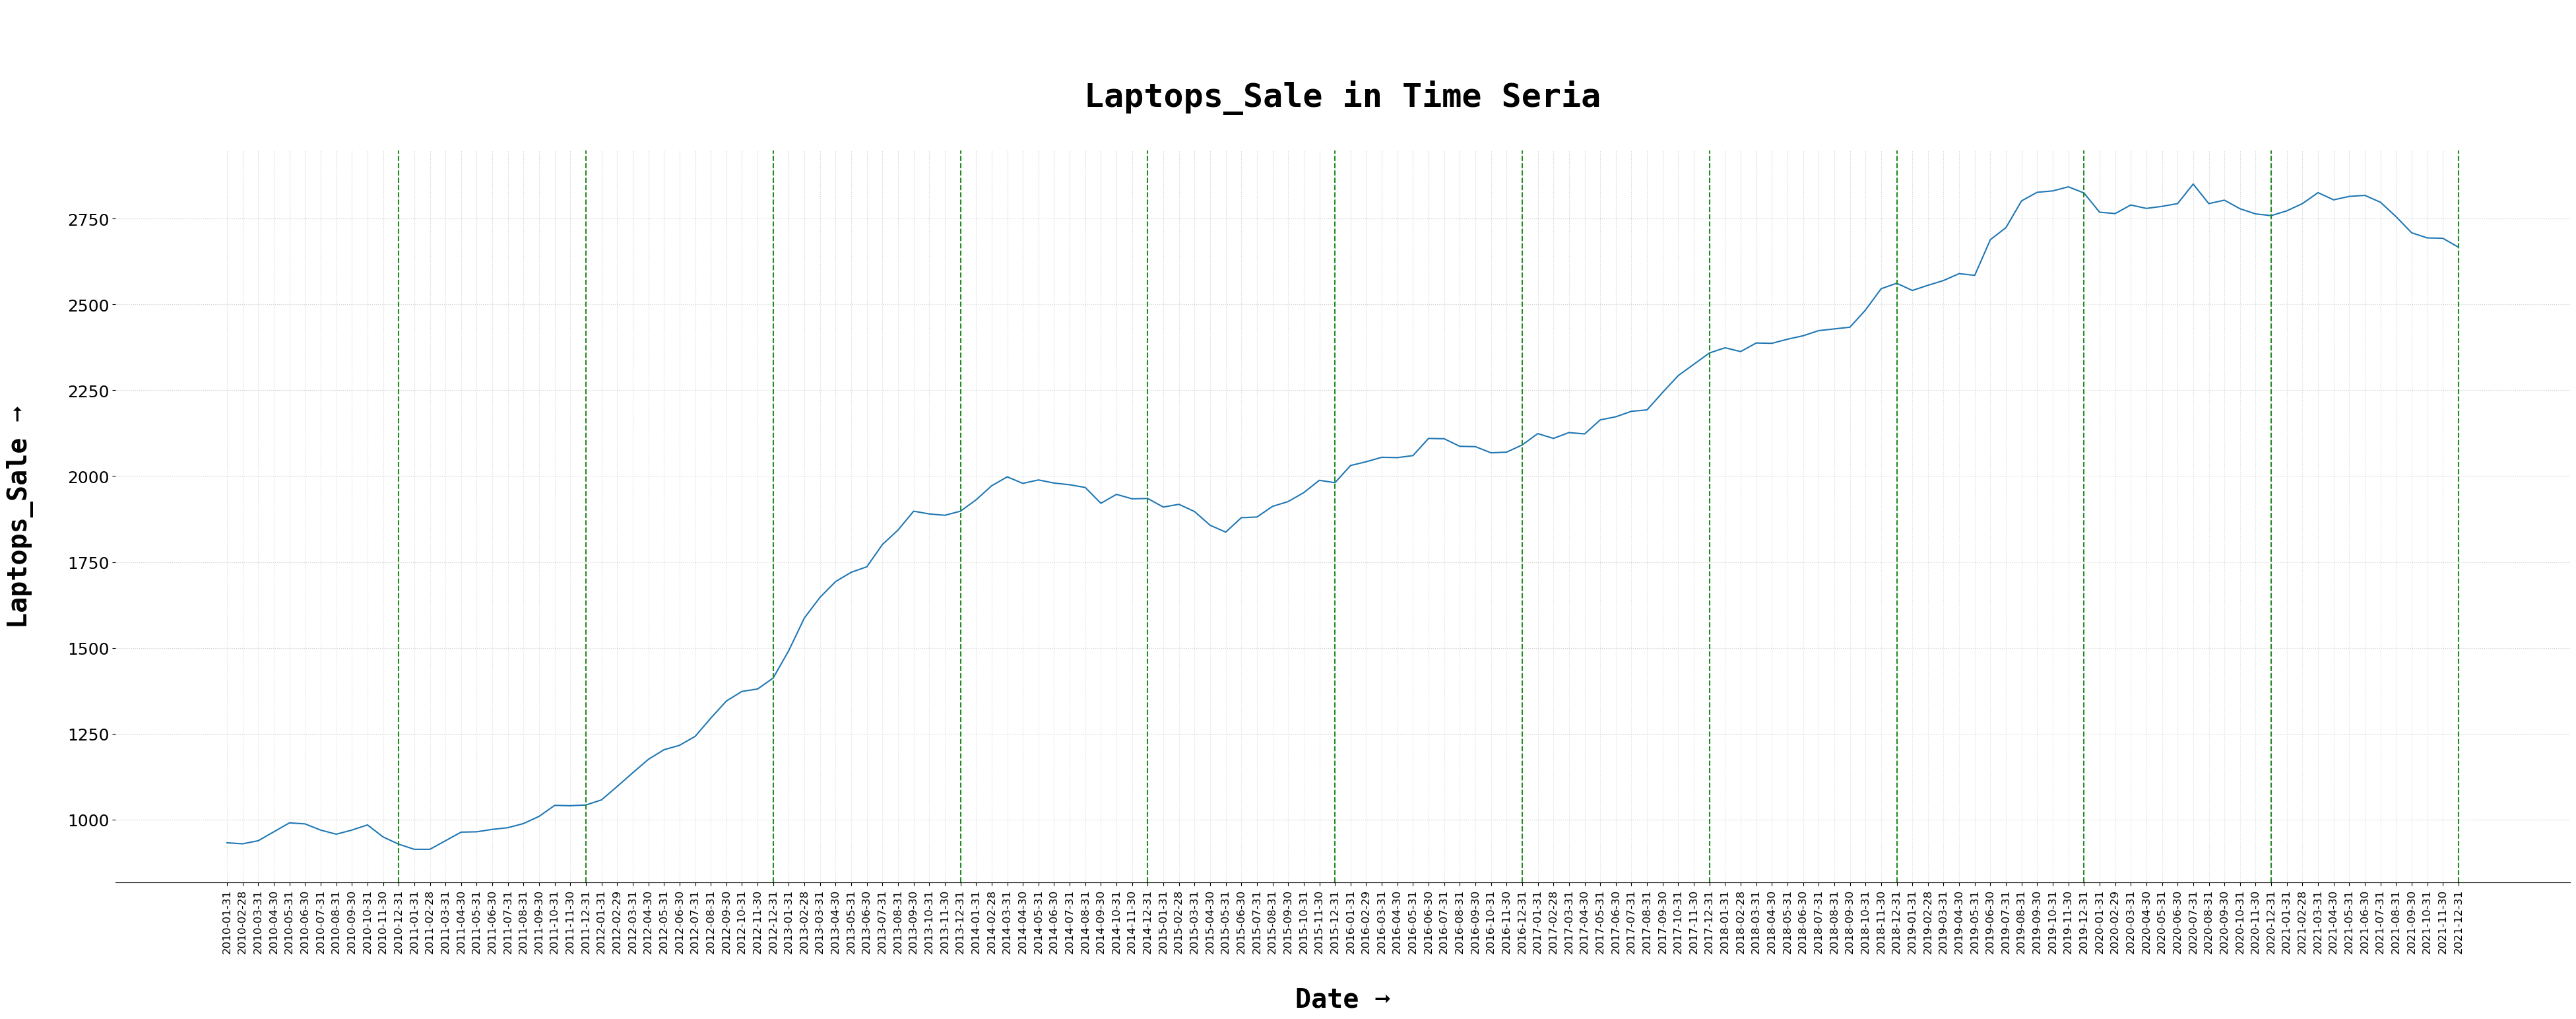

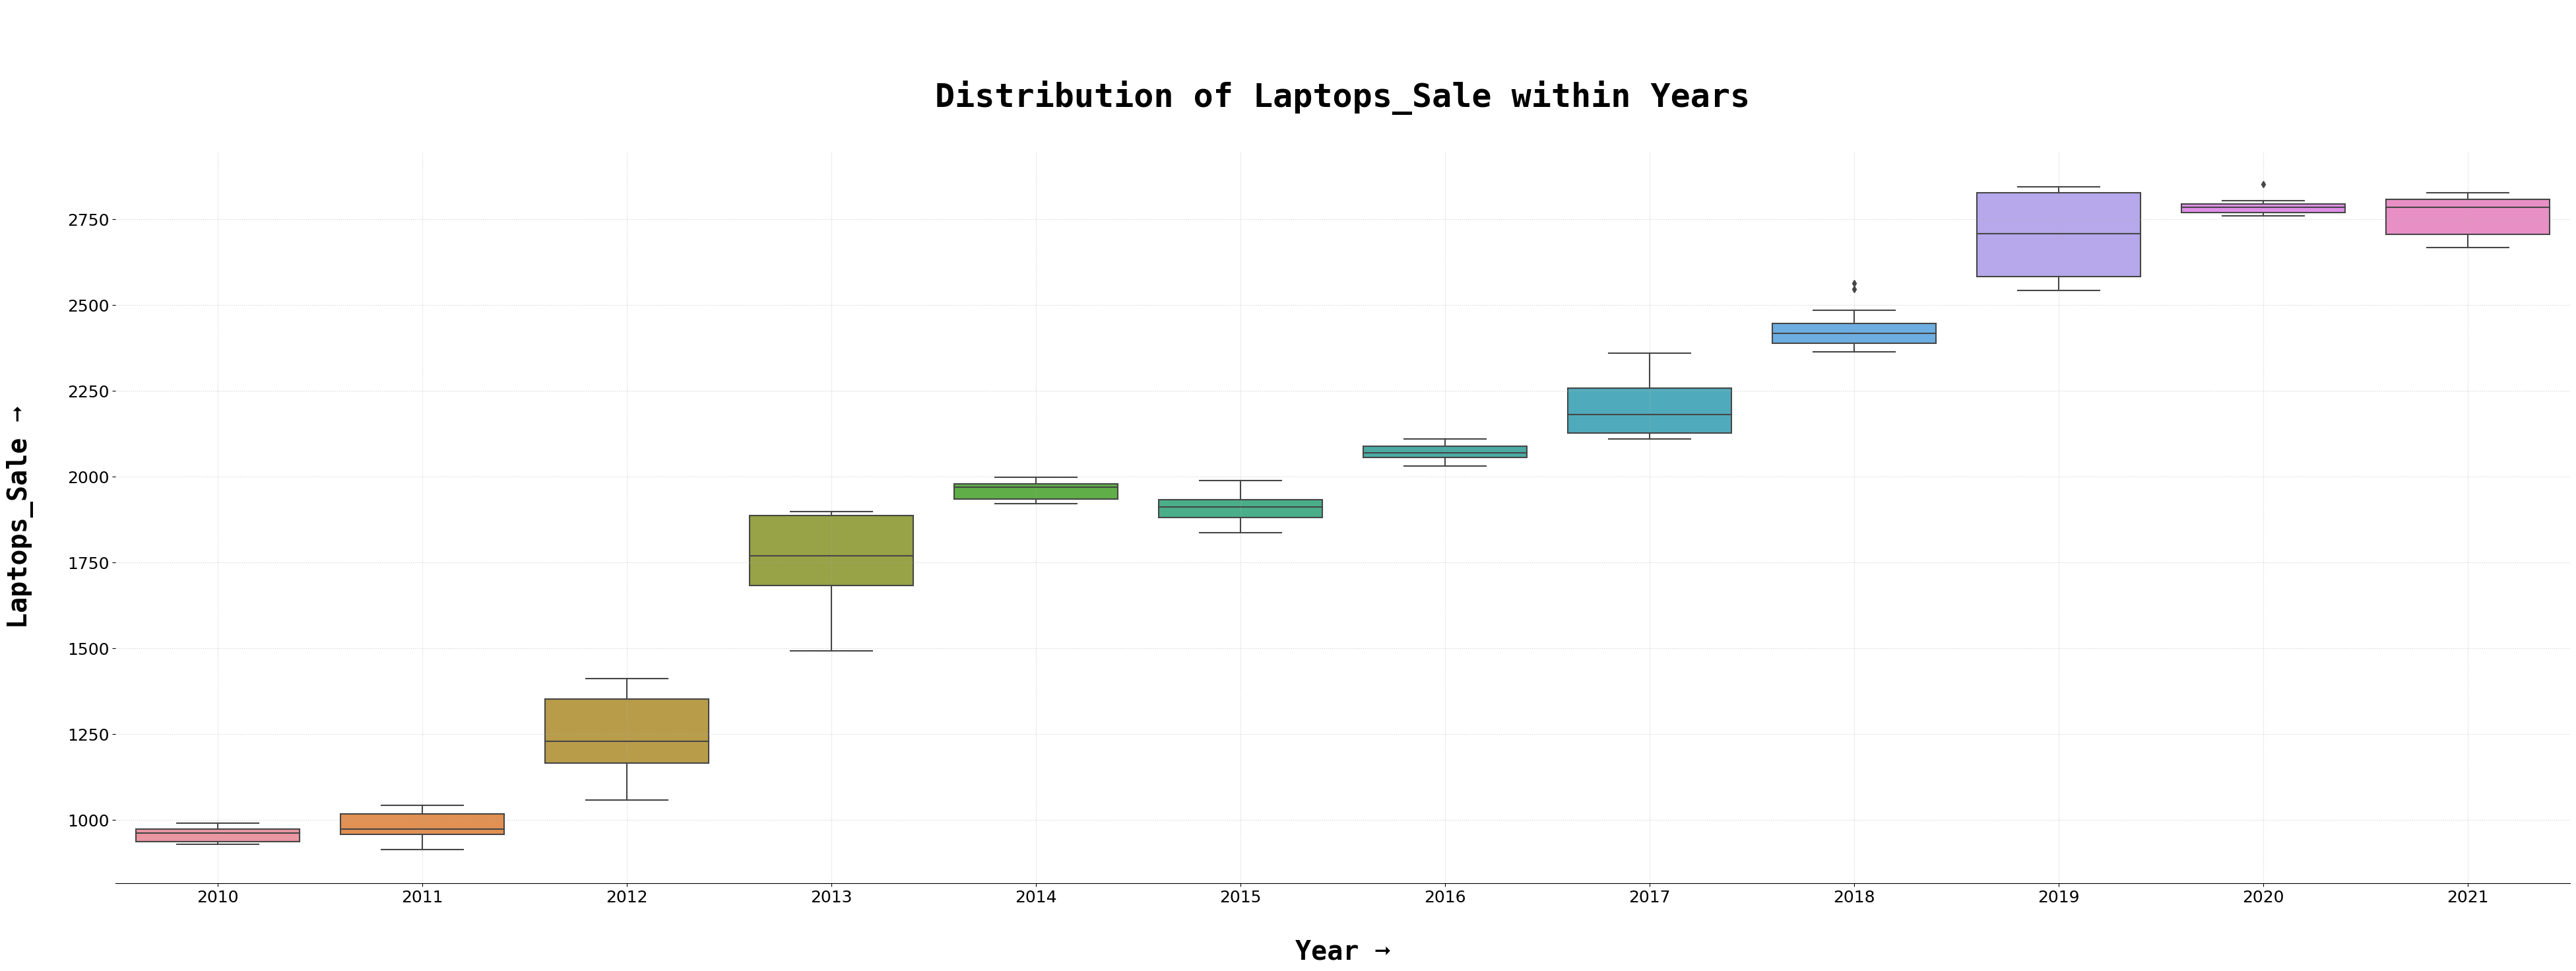

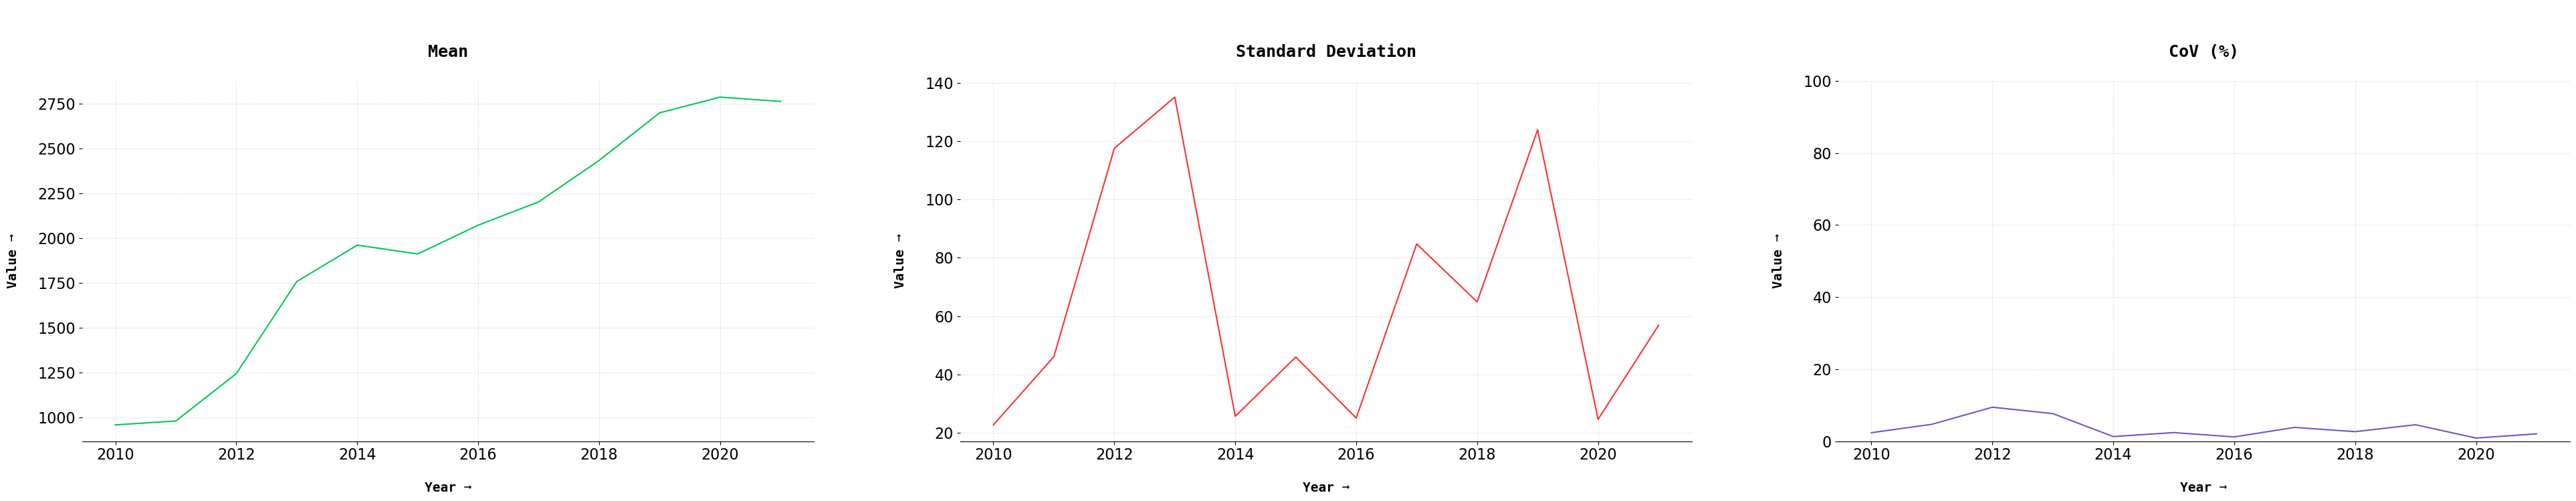

In [6]:
plot_time_seria_line_chart(df=df,
                           time_column=time_column,
                           phenomenon_column=phenomenon_column)

plot_time_seria_boxplot_per_year(df=df,
                                 time_column=time_column,
                                 phenomenon_column=phenomenon_column)

display_descriptive_statistics_per_year(df=df,
                                        time_column=time_column,
                                        phenomenon_column=phenomenon_column)

# 4. Modeling

In [7]:
X = pd.DataFrame(data={'Time':np.arange(len(df))+1})
y = df[phenomenon_column]

## --- 4.1. ARIMA ---

In [8]:
df_modeling = (df
               .set_index(time_column)
              )

## ------ 4.1.1. I (d) ------

**Diferentiation: 0, ADF test p-value: 0.239**

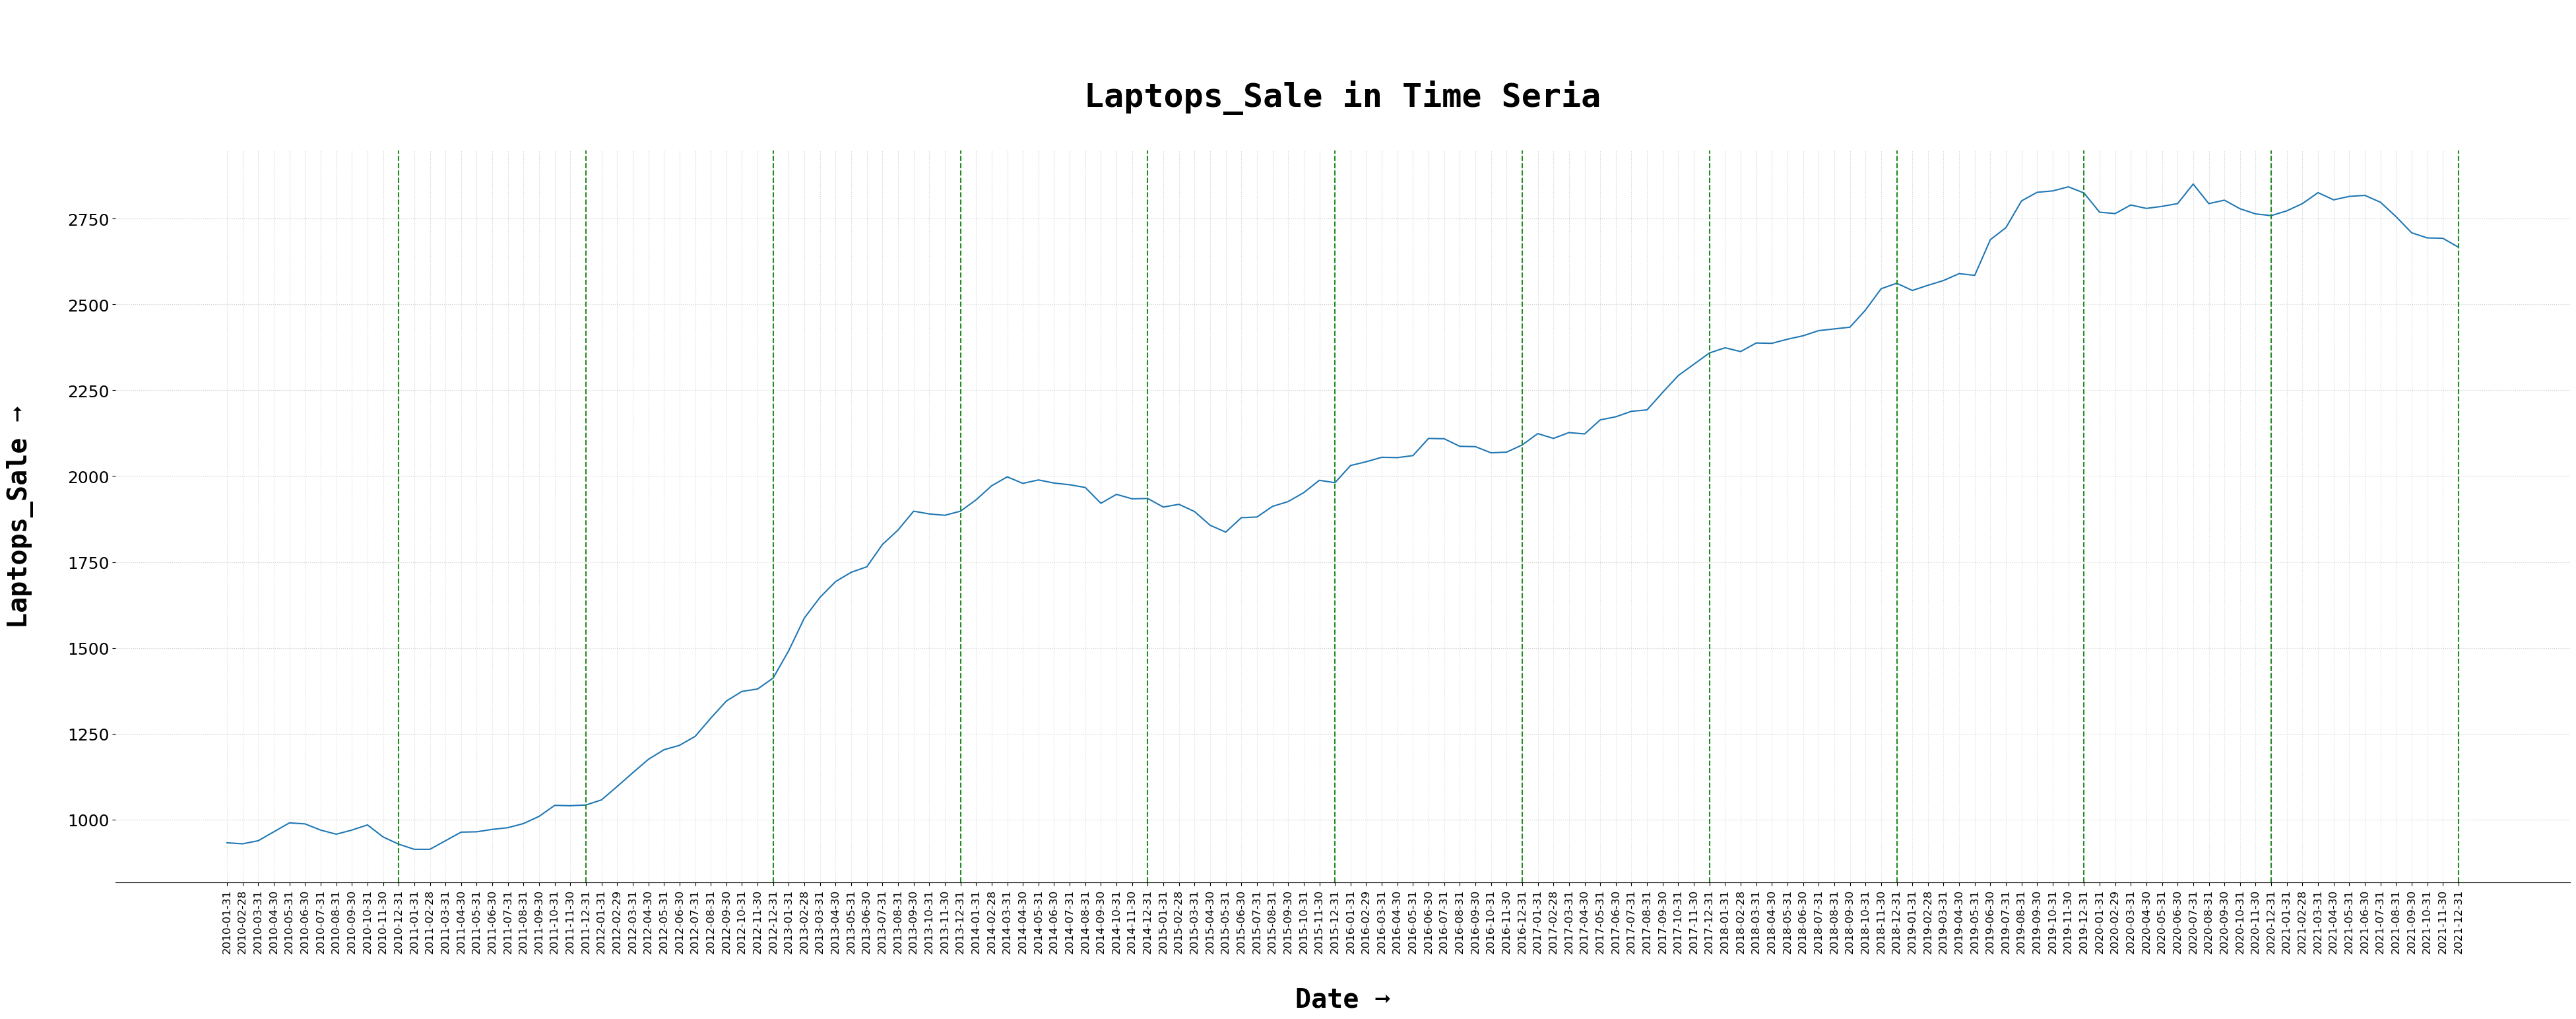

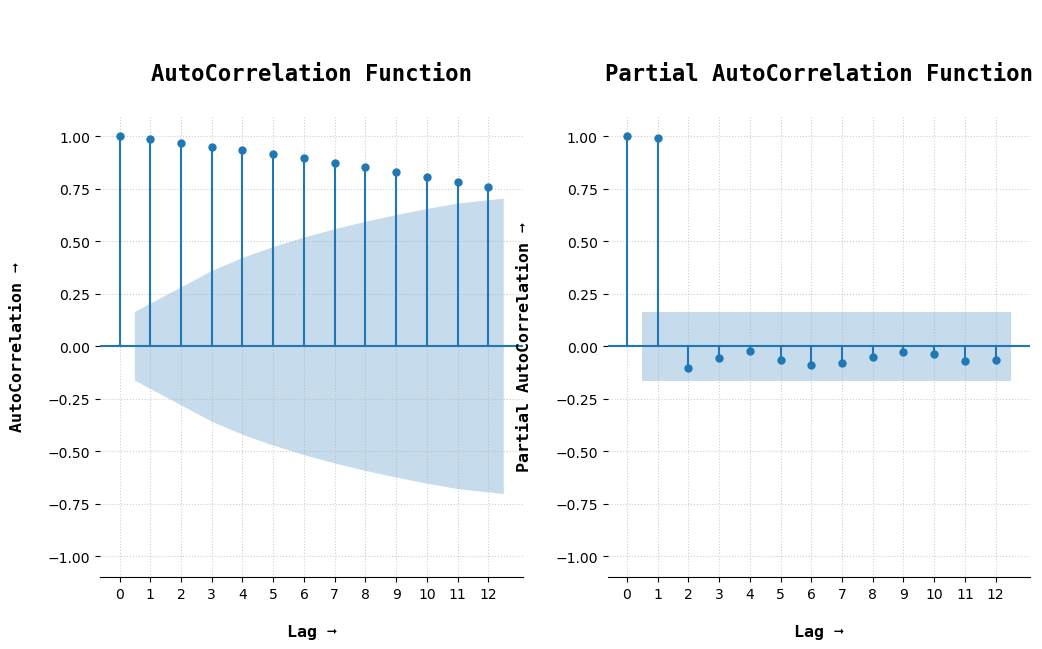

**Diferentiation: 1, ADF test p-value: 0.014**

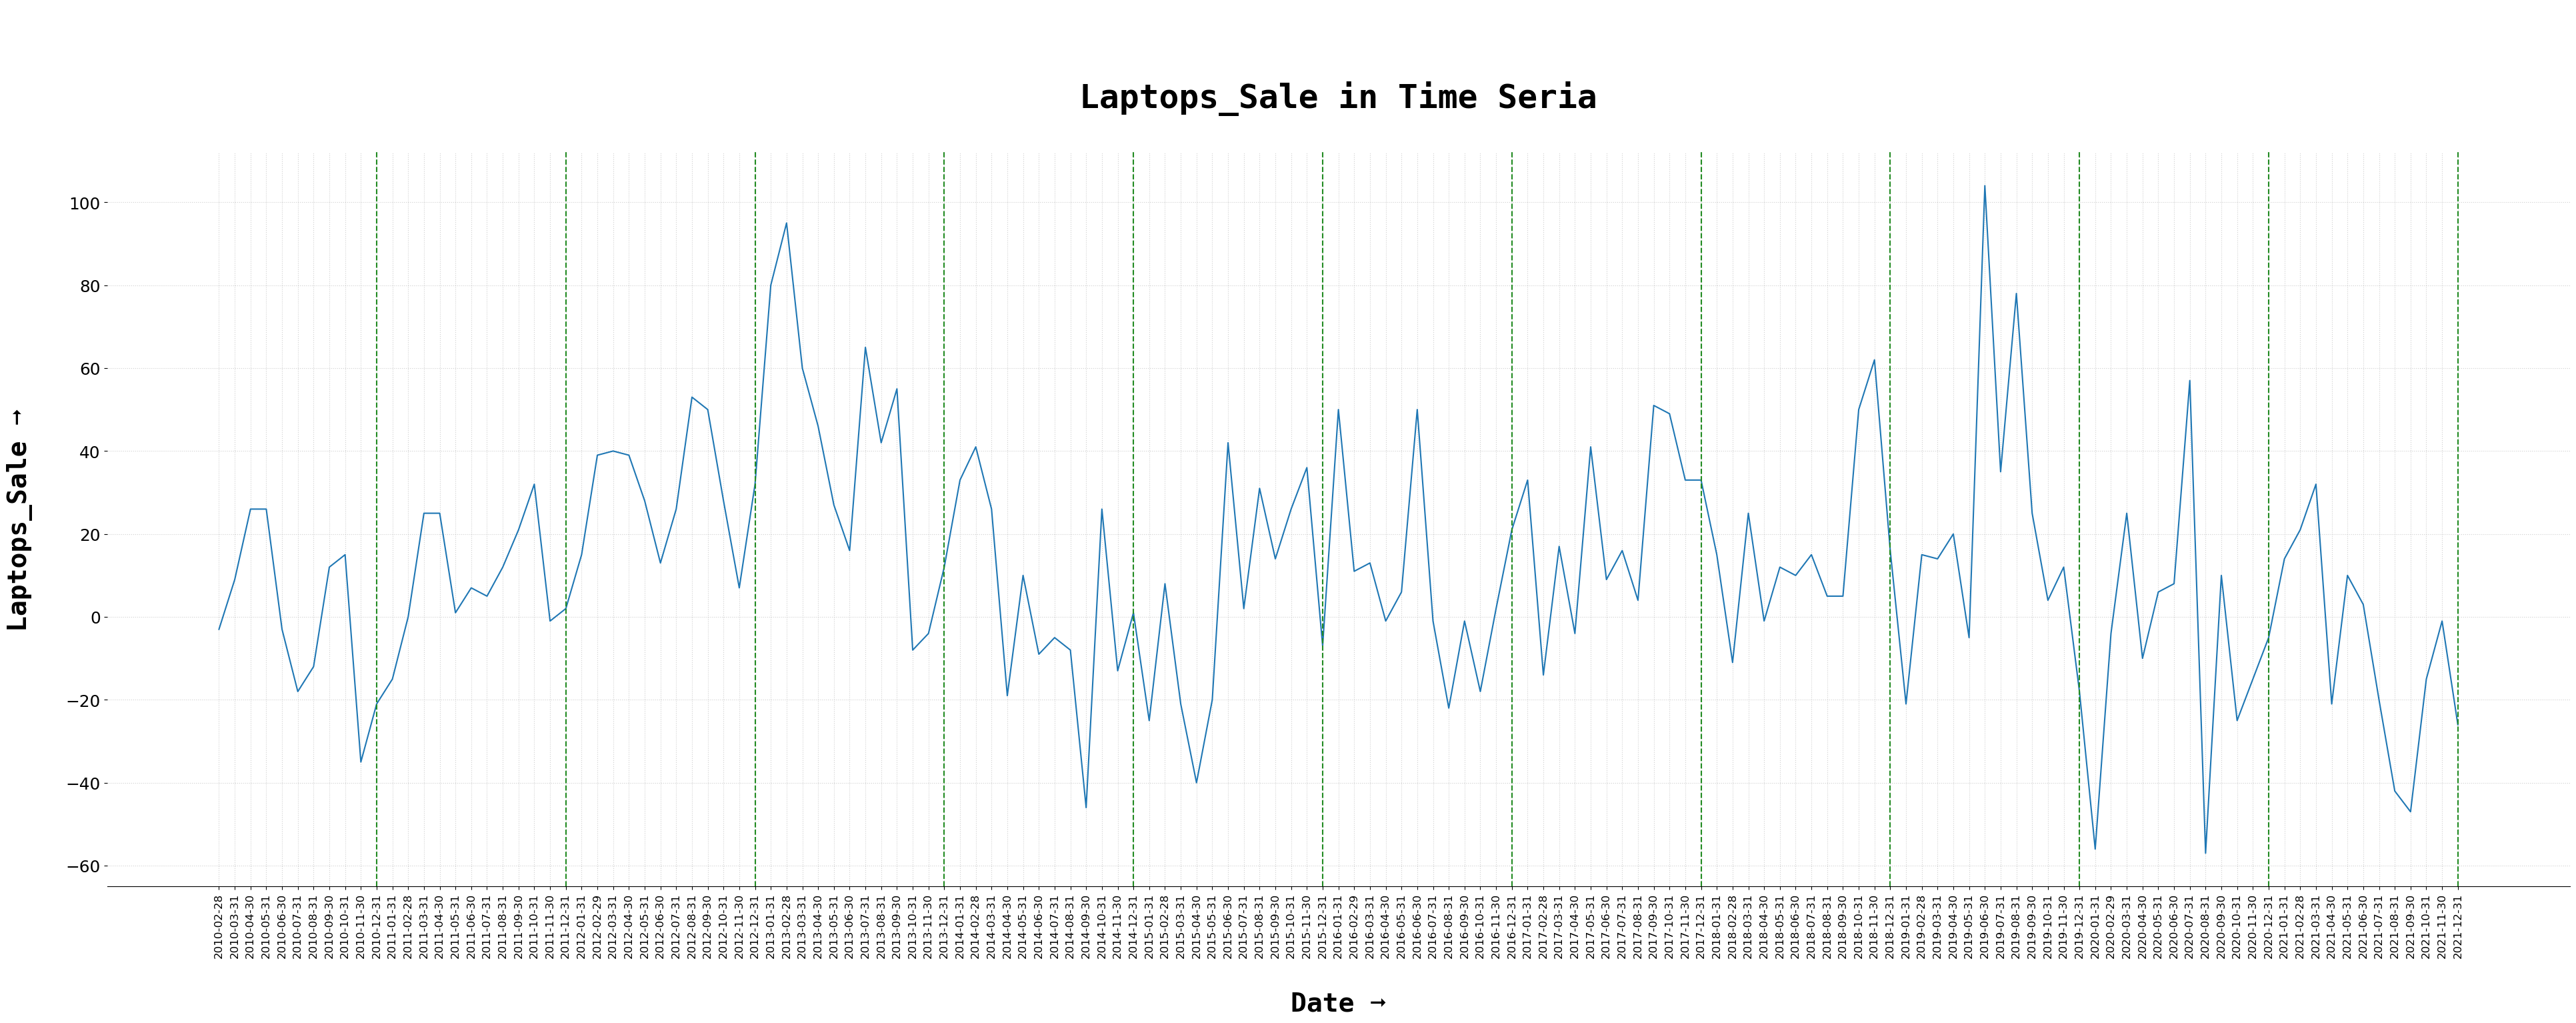

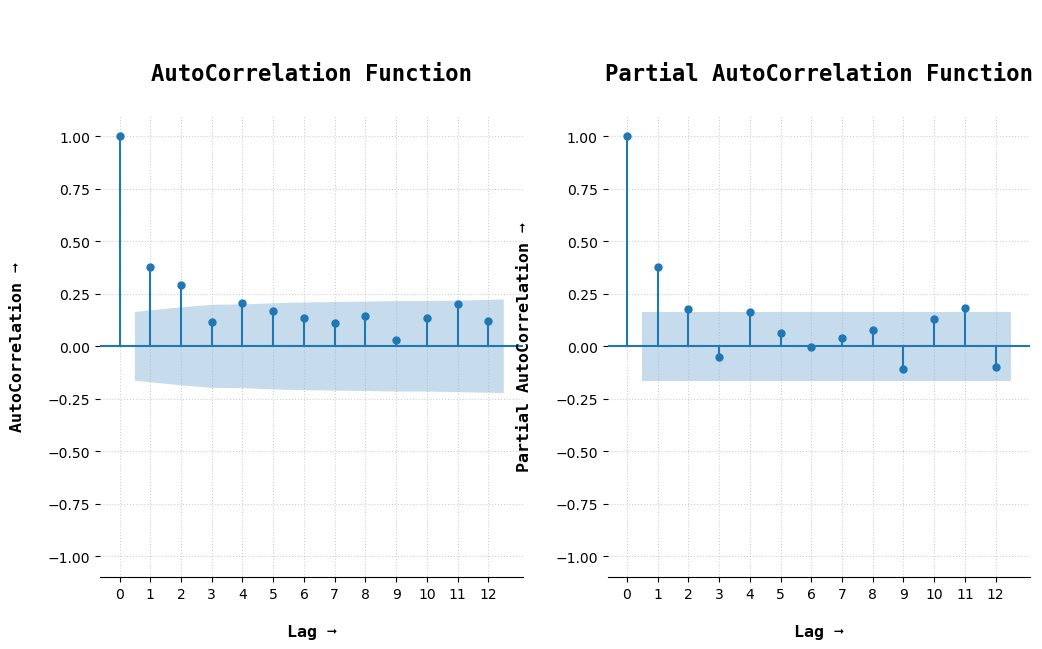

In [9]:
differentiate_until_stationarity(df=df_modeling,
                                 time_column=time_column,
                                 phenomenon_column=phenomenon_column,
                                 alpha=alpha,
                                 nlags=12)

## ------ 4.1.2. AR, MA (p, q)

In [10]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

hyperparameters_combinations = [
                                (1, 1, 0),
                                (1, 1, 1),
                                (1, 1, 2),
                                (2, 1, 0),
                                (2, 1, 1),
                                (2, 1, 2),
                                (0, 1, 1),
                                (0, 1, 2)
                               ]

for combination in hyperparameters_combinations:
    model_summary = (
                     ARIMA(df_modeling, order=(combination))
                     .fit()
                     .summary()
                    )
    
    ### 1. Significance of coefficients p-values
    p_values_coefficients = (pd.DataFrame(model_summary
                                          .tables[1]
                                          )
                             .loc[:, [4]]
                             .rename(columns={4:'p-value'})
                            )
    
    p_values_coefficients.drop(index=[0, len(p_values_coefficients)-1], inplace=True) 

    p_values_coefficients['p-value'] = (p_values_coefficients['p-value']
                                        .astype(str)
                                        .astype(float)
                                       )
    
    ### 2. Autocorrelation and Heteroscedascity
    p_values_ah = (pd.DataFrame(model_summary
                                 .tables[2]
                               )
                 .loc[[1, 3], [0, 1]]
                 .reset_index(drop=True)
                 .rename(columns={0:'Test', 1:'p-value'})
                )

    p_values_ah['Test'] = (p_values_ah['Test']
                           .astype(str)
                           .apply(lambda x: x.split(':')[0])
                           )

    p_values_ah['p-value'] = (p_values_ah['p-value']
                              .astype(str)
                              .astype(float)
                             )
    
    p_values_ah.set_index('Test', inplace=True)
        
    condition_to_retain_model = (
                                    ((p_values_coefficients['p-value'] >= alpha).astype(int).sum() == 0) & # Statistically significant coefficients
                                    ((p_values_ah.loc['Prob(Q)', 'p-value'] > alpha) & (p_values_ah.loc['Prob(H) (two-sided)', 'p-value'] > alpha)) # AutoCorrelation and Homoscedascity
                                )
    
    if condition_to_retain_model:
        display(Markdown(f'**Combination: p = {combination[0]}, d = {combination[1]}, q = {combination[2]}**'))
        print(model_summary)
        print('\n*************************************************************************************')

**Combination: p = 2, d = 1, q = 0**

                               SARIMAX Results                                
Dep. Variable:           Laptops_Sale   No. Observations:                  144
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -668.579
Date:                Tue, 22 Aug 2023   AIC                           1343.159
Time:                        17:09:17   BIC                           1352.047
Sample:                    01-31-2010   HQIC                          1346.771
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3666      0.079      4.639      0.000       0.212       0.521
ar.L2          0.2310      0.087      2.644      0.008       0.060       0.402
sigma2       672.0407     62.465     10.759      0.0

**Combination: p = 0, d = 1, q = 1**

                               SARIMAX Results                                
Dep. Variable:           Laptops_Sale   No. Observations:                  144
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -679.799
Date:                Tue, 22 Aug 2023   AIC                           1363.597
Time:                        17:09:17   BIC                           1369.523
Sample:                    01-31-2010   HQIC                          1366.005
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3146      0.076      4.163      0.000       0.167       0.463
sigma2       787.5972     73.961     10.649      0.000     642.635     932.559
Ljung-Box (L1) (Q):                   0.02   Jarque-

**Combination: p = 0, d = 1, q = 2**

                               SARIMAX Results                                
Dep. Variable:           Laptops_Sale   No. Observations:                  144
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -670.895
Date:                Tue, 22 Aug 2023   AIC                           1347.790
Time:                        17:09:17   BIC                           1356.678
Sample:                    01-31-2010   HQIC                          1351.402
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4184      0.079      5.291      0.000       0.263       0.573
ma.L2          0.3311      0.081      4.076      0.000       0.172       0.490
sigma2       694.2704     62.391     11.128      0.0

## ------ 4.1.3. Optimal AR (2), I (1), MA (0) model ------

In [11]:
optimal_combination = (2, 1, 0)

optimal_arima_model = ARIMA(df_modeling, order=optimal_combination).fit()
print(optimal_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:           Laptops_Sale   No. Observations:                  144
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -668.579
Date:                Tue, 22 Aug 2023   AIC                           1343.159
Time:                        17:09:17   BIC                           1352.047
Sample:                    01-31-2010   HQIC                          1346.771
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3666      0.079      4.639      0.000       0.212       0.521
ar.L2          0.2310      0.087      2.644      0.008       0.060       0.402
sigma2       672.0407     62.465     10.759      0.0

## ------ 4.1.4 Residuals check ------

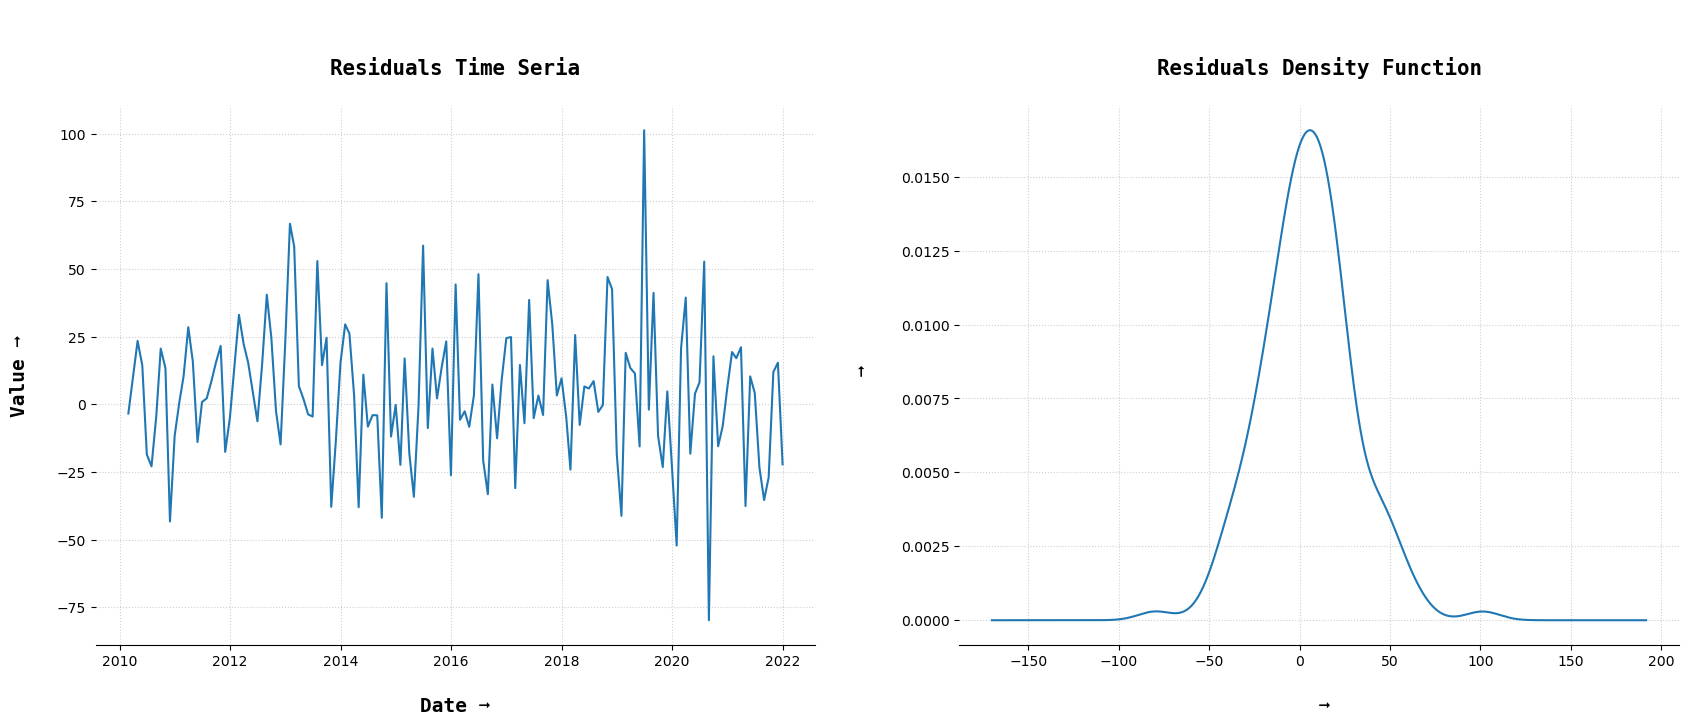

In [12]:
residuals_check(arima_model=optimal_arima_model)

## ------ 4.1.5. Forecast ------

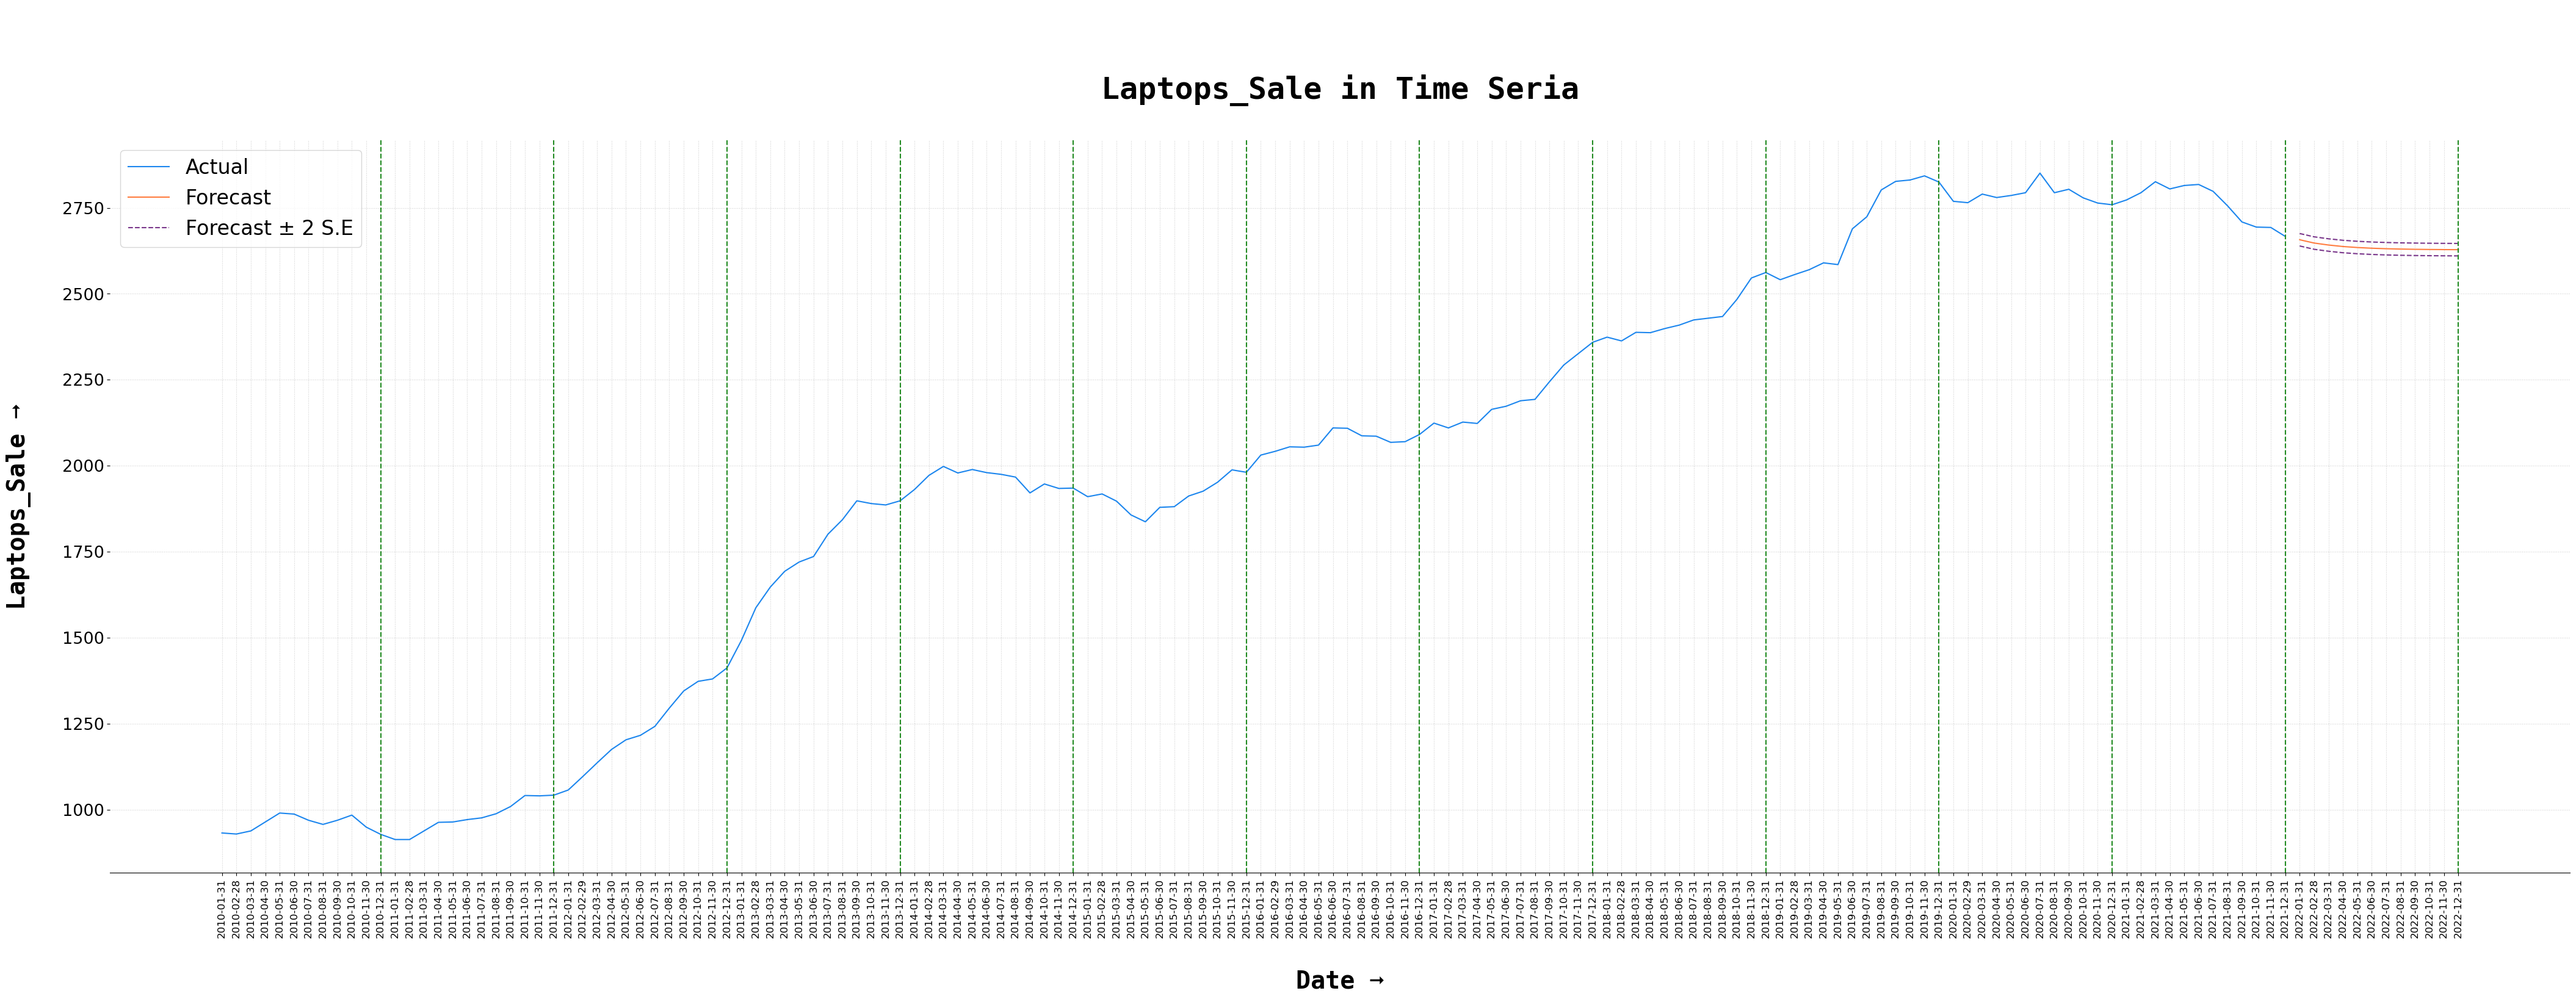

In [13]:
plot_actual_and_forecasted_values(model=optimal_arima_model,
                                  df=df_modeling,
                                  time_column=time_column,
                                  phenomenon_column=phenomenon_column,
                                  num_forcasts=12)